In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix


## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## Neural network model

In [3]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
        
        print("Depth of the network = number of hidden layers + 1:", D)
        
        for i in range(self.D):
            
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            
            stdv = 2/ np.sqrt(layers_dim[i])
            
            weight = (weight-0.5)*stdv

            weight.requires_grad = True
            
            self.weights.append(weight)
       
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [4]:
input_dim = 784
output_dim = 10
hidden_dim1 = 200

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

Depth of the network = number of hidden layers + 1: 2


## Training parameters

In [5]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

## Training loop

In [6]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []
MSE_tab = []
R_tab = []

In [7]:
batch_size: int = 1000 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        # reset the gradients from previouis iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)

        # backward pass thorught the network
        loss.backward()

        # apply the gradients
        optimizer.step()     

    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )

    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            # pass through the network            
            output: torch.Tensor = model(x)
            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))

        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network            
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))

    ########################################################################
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]

    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
    
    term_I_tab.append(term_1)
    term_II_tab.append(term_2)
    term_IV_tab.append(term_4)
    R_tab.append(R)

    term_1 = round(float(term_1), 6)
    term_2 = round(term_2, 6)

    check = round(1+ term_2 - term_4, 6)
    check2 = round(1+ term_1 + term_2 - term_4, 6)

    print(f"{e}\t{loss} \t term1: {term_1}, \t term2: {term_2} \t {check}\t {check2}")   



0	0.10512225329875946 	 term1: 0.132954, 	 term2: 0.437022 	 1.236951	 1.369905
1	0.08205121010541916 	 term1: 0.05668, 	 term2: 0.320541 	 1.014695	 1.071375
2	0.07124985754489899 	 term1: 0.027761, 	 term2: 0.265278 	 0.8874	 0.915161
3	0.06488711386919022 	 term1: 0.014483, 	 term2: 0.233218 	 0.804747	 0.81923
4	0.060646384954452515 	 term1: 0.007958, 	 term2: 0.212446 	 0.746325	 0.754283
5	0.0575980469584465 	 term1: 0.004772, 	 term2: 0.19803 	 0.702671	 0.707443
6	0.055292341858148575 	 term1: 0.003362, 	 term2: 0.187545 	 0.668802	 0.672164
7	0.05348309502005577 	 term1: 0.002935, 	 term2: 0.179652 	 0.641797	 0.644732
8	0.052023034542798996 	 term1: 0.003064, 	 term2: 0.173552 	 0.619807	 0.622871
9	0.05081813409924507 	 term1: 0.003507, 	 term2: 0.168736 	 0.601592	 0.605099
10	0.04980526491999626 	 term1: 0.004122, 	 term2: 0.164867 	 0.586286	 0.590408
11	0.048940397799015045 	 term1: 0.004826, 	 term2: 0.161709 	 0.573262	 0.578088
12	0.04819188639521599 	 term1: 0.005567

102	0.037451714277267456 	 term1: 0.02649, 	 term2: 0.138325 	 0.42222	 0.44871
103	0.037425294518470764 	 term1: 0.026574, 	 term2: 0.138354 	 0.421908	 0.448482
104	0.03739926591515541 	 term1: 0.026658, 	 term2: 0.138384 	 0.4216	 0.448258
105	0.03737363591790199 	 term1: 0.026741, 	 term2: 0.138415 	 0.421298	 0.448039
106	0.037348393350839615 	 term1: 0.026823, 	 term2: 0.138446 	 0.420999	 0.447822
107	0.037323515862226486 	 term1: 0.026904, 	 term2: 0.138478 	 0.420706	 0.44761
108	0.037299007177352905 	 term1: 0.026985, 	 term2: 0.13851 	 0.420416	 0.447401
109	0.037274859845638275 	 term1: 0.027064, 	 term2: 0.138543 	 0.420131	 0.447195
110	0.0372510589659214 	 term1: 0.027143, 	 term2: 0.138576 	 0.419849	 0.446992
111	0.03722759708762169 	 term1: 0.027221, 	 term2: 0.13861 	 0.419572	 0.446793
112	0.03720446676015854 	 term1: 0.027299, 	 term2: 0.138645 	 0.419299	 0.446598
113	0.037181660532951355 	 term1: 0.027375, 	 term2: 0.138679 	 0.419029	 0.446404
114	0.037159178406

203	0.03591077774763107 	 term1: 0.032298, 	 term2: 0.142466 	 0.404148	 0.436446
204	0.03590181842446327 	 term1: 0.032338, 	 term2: 0.142508 	 0.404045	 0.436383
205	0.03589293733239174 	 term1: 0.032378, 	 term2: 0.142551 	 0.403944	 0.436322
206	0.03588411957025528 	 term1: 0.032417, 	 term2: 0.142593 	 0.403843	 0.43626
207	0.03587537258863449 	 term1: 0.032456, 	 term2: 0.142635 	 0.403743	 0.436199
208	0.03586668521165848 	 term1: 0.032496, 	 term2: 0.142678 	 0.403644	 0.43614
209	0.035858068615198135 	 term1: 0.032534, 	 term2: 0.14272 	 0.403545	 0.436079
210	0.03584951534867287 	 term1: 0.032573, 	 term2: 0.142762 	 0.403448	 0.436021
211	0.035841021686792374 	 term1: 0.032611, 	 term2: 0.142804 	 0.403351	 0.435962
212	0.03583259508013725 	 term1: 0.03265, 	 term2: 0.142846 	 0.403255	 0.435905
213	0.035824235528707504 	 term1: 0.032688, 	 term2: 0.142888 	 0.403159	 0.435847
214	0.03581593185663223 	 term1: 0.032725, 	 term2: 0.142929 	 0.403064	 0.435789
215	0.03580768406

304	0.035253021866083145 	 term1: 0.035467, 	 term2: 0.146372 	 0.396807	 0.432274
305	0.0352482795715332 	 term1: 0.035492, 	 term2: 0.146407 	 0.396756	 0.432248
306	0.03524356335401535 	 term1: 0.035517, 	 term2: 0.146441 	 0.396705	 0.432222
307	0.03523886576294899 	 term1: 0.035541, 	 term2: 0.146476 	 0.396655	 0.432196
308	0.03523419797420502 	 term1: 0.035565, 	 term2: 0.14651 	 0.396604	 0.432169
309	0.035229556262493134 	 term1: 0.03559, 	 term2: 0.146544 	 0.396554	 0.432144
310	0.03522493317723274 	 term1: 0.035614, 	 term2: 0.146578 	 0.396504	 0.432118
311	0.03522033616900444 	 term1: 0.035638, 	 term2: 0.146612 	 0.396455	 0.432093
312	0.03521576151251793 	 term1: 0.035662, 	 term2: 0.146646 	 0.396406	 0.432068
313	0.03521120920777321 	 term1: 0.035686, 	 term2: 0.14668 	 0.396357	 0.432043
314	0.03520668298006058 	 term1: 0.035709, 	 term2: 0.146714 	 0.396308	 0.432017
315	0.03520217910408974 	 term1: 0.035733, 	 term2: 0.146748 	 0.39626	 0.431993
316	0.0351976901292

405	0.03487219661474228 	 term1: 0.037536, 	 term2: 0.149481 	 0.39281	 0.430346
406	0.03486920893192291 	 term1: 0.037553, 	 term2: 0.149508 	 0.392779	 0.430332
407	0.03486622869968414 	 term1: 0.03757, 	 term2: 0.149536 	 0.392749	 0.430319
408	0.03486325964331627 	 term1: 0.037587, 	 term2: 0.149563 	 0.392719	 0.430306
409	0.03486030921339989 	 term1: 0.037604, 	 term2: 0.14959 	 0.392689	 0.430293
410	0.034857362508773804 	 term1: 0.03762, 	 term2: 0.149617 	 0.392659	 0.430279
411	0.03485443815588951 	 term1: 0.037637, 	 term2: 0.149644 	 0.39263	 0.430267
412	0.03485151380300522 	 term1: 0.037654, 	 term2: 0.14967 	 0.392599	 0.430253
413	0.03484861180186272 	 term1: 0.03767, 	 term2: 0.149697 	 0.39257	 0.43024
414	0.03484571352601051 	 term1: 0.037687, 	 term2: 0.149724 	 0.392541	 0.430228
415	0.034842830151319504 	 term1: 0.037703, 	 term2: 0.149751 	 0.392512	 0.430215
416	0.03483995795249939 	 term1: 0.03772, 	 term2: 0.149777 	 0.392482	 0.430202
417	0.03483709692955017 

506	0.0346207469701767 	 term1: 0.039004, 	 term2: 0.151933 	 0.390308	 0.429312
507	0.03461868315935135 	 term1: 0.039016, 	 term2: 0.151954 	 0.390287	 0.429303
508	0.034616619348526 	 term1: 0.039029, 	 term2: 0.151976 	 0.390268	 0.429297
509	0.03461457043886185 	 term1: 0.039041, 	 term2: 0.151997 	 0.390247	 0.429288
510	0.03461252525448799 	 term1: 0.039053, 	 term2: 0.152019 	 0.390228	 0.429281
511	0.03461048752069473 	 term1: 0.039066, 	 term2: 0.15204 	 0.390208	 0.429274
512	0.03460845351219177 	 term1: 0.039078, 	 term2: 0.152061 	 0.390188	 0.429266
513	0.03460642695426941 	 term1: 0.03909, 	 term2: 0.152083 	 0.390169	 0.429259
514	0.03460441157221794 	 term1: 0.039102, 	 term2: 0.152104 	 0.390149	 0.429251
515	0.03460239991545677 	 term1: 0.039114, 	 term2: 0.152125 	 0.39013	 0.429244
516	0.0346003919839859 	 term1: 0.039126, 	 term2: 0.152146 	 0.39011	 0.429236
517	0.03459839150309563 	 term1: 0.039138, 	 term2: 0.152167 	 0.390091	 0.429229
518	0.03459640219807625 

607	0.03444188833236694 	 term1: 0.040099, 	 term2: 0.153885 	 0.388601	 0.4287
608	0.034440379589796066 	 term1: 0.040109, 	 term2: 0.153902 	 0.388587	 0.428696
609	0.03443887084722519 	 term1: 0.040118, 	 term2: 0.153919 	 0.388573	 0.428691
610	0.03443736582994461 	 term1: 0.040128, 	 term2: 0.153937 	 0.388559	 0.428687
611	0.03443586453795433 	 term1: 0.040137, 	 term2: 0.153954 	 0.388545	 0.428682
612	0.03443437069654465 	 term1: 0.040147, 	 term2: 0.153971 	 0.388531	 0.428678
613	0.03443288430571556 	 term1: 0.040156, 	 term2: 0.153988 	 0.388517	 0.428673
614	0.034431394189596176 	 term1: 0.040165, 	 term2: 0.154005 	 0.388503	 0.428668
615	0.03442991152405739 	 term1: 0.040174, 	 term2: 0.154022 	 0.388489	 0.428663
616	0.0344284288585186 	 term1: 0.040184, 	 term2: 0.154039 	 0.388475	 0.428659
617	0.03442695736885071 	 term1: 0.040193, 	 term2: 0.154056 	 0.388462	 0.428655
618	0.034425489604473114 	 term1: 0.040202, 	 term2: 0.154073 	 0.388448	 0.42865
619	0.03442402556

708	0.03430834040045738 	 term1: 0.040947, 	 term2: 0.155461 	 0.387367	 0.428314
709	0.03430718928575516 	 term1: 0.040955, 	 term2: 0.155475 	 0.387357	 0.428312
710	0.03430603817105293 	 term1: 0.040962, 	 term2: 0.155489 	 0.387346	 0.428308
711	0.034304890781641006 	 term1: 0.04097, 	 term2: 0.155503 	 0.387336	 0.428306
712	0.03430374711751938 	 term1: 0.040977, 	 term2: 0.155517 	 0.387325	 0.428302
713	0.03430261090397835 	 term1: 0.040984, 	 term2: 0.155531 	 0.387315	 0.428299
714	0.03430147096514702 	 term1: 0.040992, 	 term2: 0.155545 	 0.387305	 0.428297
715	0.03430033475160599 	 term1: 0.040999, 	 term2: 0.155559 	 0.387294	 0.428293
716	0.034299202263355255 	 term1: 0.041006, 	 term2: 0.155572 	 0.387283	 0.428289
717	0.03429806977510452 	 term1: 0.041014, 	 term2: 0.155586 	 0.387273	 0.428287
718	0.034296948462724686 	 term1: 0.041021, 	 term2: 0.1556 	 0.387263	 0.428284
719	0.03429582342505455 	 term1: 0.041028, 	 term2: 0.155614 	 0.387253	 0.428281
720	0.0342947021

809	0.034205082803964615 	 term1: 0.041622, 	 term2: 0.156751 	 0.386434	 0.428056
810	0.03420417755842209 	 term1: 0.041628, 	 term2: 0.156763 	 0.386426	 0.428054
811	0.03420327231287956 	 term1: 0.041634, 	 term2: 0.156774 	 0.386417	 0.428051
812	0.03420237824320793 	 term1: 0.04164, 	 term2: 0.156786 	 0.38641	 0.42805
813	0.034201476722955704 	 term1: 0.041645, 	 term2: 0.156797 	 0.386401	 0.428046
814	0.03420058637857437 	 term1: 0.041651, 	 term2: 0.156809 	 0.386393	 0.428044
815	0.034199684858322144 	 term1: 0.041657, 	 term2: 0.15682 	 0.386385	 0.428042
816	0.03419879451394081 	 term1: 0.041663, 	 term2: 0.156832 	 0.386378	 0.428041
817	0.03419790416955948 	 term1: 0.041669, 	 term2: 0.156843 	 0.386369	 0.428038
818	0.034197017550468445 	 term1: 0.041675, 	 term2: 0.156855 	 0.386362	 0.428037
819	0.03419613093137741 	 term1: 0.041681, 	 term2: 0.156866 	 0.386353	 0.428034
820	0.034195251762866974 	 term1: 0.041687, 	 term2: 0.156877 	 0.386345	 0.428032
821	0.034194365

910	0.03412312641739845 	 term1: 0.04217, 	 term2: 0.157822 	 0.385704	 0.427874
911	0.034122396260499954 	 term1: 0.042175, 	 term2: 0.157832 	 0.385698	 0.427873
912	0.03412167727947235 	 term1: 0.042179, 	 term2: 0.157841 	 0.385691	 0.42787
913	0.03412095457315445 	 term1: 0.042184, 	 term2: 0.157851 	 0.385685	 0.427869
914	0.03412022814154625 	 term1: 0.042189, 	 term2: 0.157861 	 0.385679	 0.427868
915	0.03411950543522835 	 term1: 0.042194, 	 term2: 0.15787 	 0.385672	 0.427866
916	0.03411879017949104 	 term1: 0.042199, 	 term2: 0.15788 	 0.385666	 0.427865
917	0.03411807119846344 	 term1: 0.042204, 	 term2: 0.15789 	 0.38566	 0.427864
918	0.034117355942726135 	 term1: 0.042209, 	 term2: 0.157899 	 0.385653	 0.427862
919	0.03411664068698883 	 term1: 0.042213, 	 term2: 0.157909 	 0.385647	 0.42786
920	0.034115929156541824 	 term1: 0.042218, 	 term2: 0.157918 	 0.38564	 0.427858
921	0.03411522135138512 	 term1: 0.042223, 	 term2: 0.157928 	 0.385634	 0.427857
922	0.034114509820938

1010	0.03405731916427612 	 term1: 0.042619, 	 term2: 0.158714 	 0.385123	 0.427742
1011	0.03405672311782837 	 term1: 0.042623, 	 term2: 0.158722 	 0.385117	 0.42774
1012	0.034056130796670914 	 term1: 0.042627, 	 term2: 0.15873 	 0.385112	 0.427739
1013	0.03405553475022316 	 term1: 0.042631, 	 term2: 0.158738 	 0.385106	 0.427737
1014	0.034054942429065704 	 term1: 0.042635, 	 term2: 0.158747 	 0.385102	 0.427737
1015	0.034054357558488846 	 term1: 0.04264, 	 term2: 0.158755 	 0.385097	 0.427737
1016	0.03405376896262169 	 term1: 0.042644, 	 term2: 0.158763 	 0.385091	 0.427735
1017	0.03405318036675453 	 term1: 0.042648, 	 term2: 0.158771 	 0.385086	 0.427734
1018	0.034052591770887375 	 term1: 0.042652, 	 term2: 0.158779 	 0.385081	 0.427733
1019	0.034052006900310516 	 term1: 0.042656, 	 term2: 0.158787 	 0.385075	 0.427731
1020	0.034051425755023956 	 term1: 0.04266, 	 term2: 0.158795 	 0.38507	 0.42773
1021	0.0340508408844471 	 term1: 0.042664, 	 term2: 0.158803 	 0.385065	 0.427729
1022	

1109	0.03400351107120514 	 term1: 0.042994, 	 term2: 0.159466 	 0.384648	 0.427642
1110	0.034003015607595444 	 term1: 0.042998, 	 term2: 0.159473 	 0.384644	 0.427642
1111	0.03400251641869545 	 term1: 0.043001, 	 term2: 0.15948 	 0.384639	 0.42764
1112	0.03400202468037605 	 term1: 0.043004, 	 term2: 0.159487 	 0.384635	 0.427639
1113	0.034001536667346954 	 term1: 0.043008, 	 term2: 0.159494 	 0.384631	 0.427639
1114	0.03400104492902756 	 term1: 0.043011, 	 term2: 0.159501 	 0.384626	 0.427637
1115	0.03400055319070816 	 term1: 0.043015, 	 term2: 0.159508 	 0.384622	 0.427637
1116	0.03400006145238876 	 term1: 0.043018, 	 term2: 0.159515 	 0.384618	 0.427636
1117	0.03399957716464996 	 term1: 0.043022, 	 term2: 0.159522 	 0.384613	 0.427635
1118	0.033999089151620865 	 term1: 0.043025, 	 term2: 0.159529 	 0.384609	 0.427634
1119	0.03399859741330147 	 term1: 0.043029, 	 term2: 0.159536 	 0.384605	 0.427634
1120	0.03399810940027237 	 term1: 0.043032, 	 term2: 0.159543 	 0.384601	 0.427633
112

1208	0.03395842760801315 	 term1: 0.043314, 	 term2: 0.160114 	 0.38425	 0.427564
1209	0.033958010375499725 	 term1: 0.043317, 	 term2: 0.16012 	 0.384246	 0.427563
1210	0.0339575931429863 	 term1: 0.04332, 	 term2: 0.160126 	 0.384242	 0.427562
1211	0.03395717591047287 	 term1: 0.043323, 	 term2: 0.160132 	 0.384239	 0.427562
1212	0.03395675867795944 	 term1: 0.043326, 	 term2: 0.160138 	 0.384235	 0.427561
1213	0.03395634889602661 	 term1: 0.043329, 	 term2: 0.160144 	 0.384231	 0.42756
1214	0.03395593538880348 	 term1: 0.043332, 	 term2: 0.16015 	 0.384228	 0.42756
1215	0.033955518156290054 	 term1: 0.043335, 	 term2: 0.160156 	 0.384224	 0.427559
1216	0.033955108374357224 	 term1: 0.043338, 	 term2: 0.160162 	 0.38422	 0.427558
1217	0.033954694867134094 	 term1: 0.043341, 	 term2: 0.160168 	 0.384217	 0.427558
1218	0.033954281359910965 	 term1: 0.043344, 	 term2: 0.160174 	 0.384213	 0.427557
1219	0.033953871577978134 	 term1: 0.043347, 	 term2: 0.16018 	 0.384209	 0.427556
1220	0.

1307	0.03392023220658302 	 term1: 0.043591, 	 term2: 0.160676 	 0.383909	 0.4275
1308	0.03391987830400467 	 term1: 0.043593, 	 term2: 0.160682 	 0.383907	 0.4275
1309	0.033919524401426315 	 term1: 0.043596, 	 term2: 0.160687 	 0.383903	 0.427499
1310	0.03391916677355766 	 term1: 0.043599, 	 term2: 0.160692 	 0.3839	 0.427499
1311	0.03391881659626961 	 term1: 0.043601, 	 term2: 0.160697 	 0.383897	 0.427498
1312	0.03391846641898155 	 term1: 0.043604, 	 term2: 0.160703 	 0.383894	 0.427498
1313	0.0339181125164032 	 term1: 0.043606, 	 term2: 0.160708 	 0.383891	 0.427497
1314	0.033917758613824844 	 term1: 0.043609, 	 term2: 0.160713 	 0.383887	 0.427496
1315	0.03391740843653679 	 term1: 0.043611, 	 term2: 0.160719 	 0.383885	 0.427496
1316	0.033917054533958435 	 term1: 0.043614, 	 term2: 0.160724 	 0.383881	 0.427495
1317	0.03391670435667038 	 term1: 0.043617, 	 term2: 0.160729 	 0.383878	 0.427495
1318	0.033916354179382324 	 term1: 0.043619, 	 term2: 0.160734 	 0.383875	 0.427494
1319	0.

1406	0.03388756513595581 	 term1: 0.043832, 	 term2: 0.16117 	 0.383616	 0.427448
1407	0.03388725966215134 	 term1: 0.043834, 	 term2: 0.161174 	 0.383613	 0.427447
1408	0.03388695791363716 	 term1: 0.043837, 	 term2: 0.161179 	 0.383611	 0.427448
1409	0.03388665243983269 	 term1: 0.043839, 	 term2: 0.161184 	 0.383608	 0.427447
1410	0.03388635069131851 	 term1: 0.043841, 	 term2: 0.161188 	 0.383605	 0.427446
1411	0.03388604521751404 	 term1: 0.043843, 	 term2: 0.161193 	 0.383602	 0.427445
1412	0.03388574346899986 	 term1: 0.043846, 	 term2: 0.161198 	 0.3836	 0.427446
1413	0.03388544172048569 	 term1: 0.043848, 	 term2: 0.161202 	 0.383597	 0.427445
1414	0.03388513624668121 	 term1: 0.04385, 	 term2: 0.161207 	 0.383594	 0.427444
1415	0.03388483449816704 	 term1: 0.043852, 	 term2: 0.161211 	 0.383591	 0.427443
1416	0.033884529024362564 	 term1: 0.043855, 	 term2: 0.161216 	 0.383588	 0.427443
1417	0.03388422727584839 	 term1: 0.043857, 	 term2: 0.161221 	 0.383586	 0.427443
1418	0.

1505	0.03385939821600914 	 term1: 0.044044, 	 term2: 0.161605 	 0.383359	 0.427403
1506	0.03385912999510765 	 term1: 0.044046, 	 term2: 0.161609 	 0.383356	 0.427402
1507	0.03385886922478676 	 term1: 0.044048, 	 term2: 0.161614 	 0.383355	 0.427403
1508	0.03385860472917557 	 term1: 0.04405, 	 term2: 0.161618 	 0.383352	 0.427402
1509	0.03385833650827408 	 term1: 0.044052, 	 term2: 0.161622 	 0.38335	 0.427402
1510	0.033858075737953186 	 term1: 0.044054, 	 term2: 0.161626 	 0.383347	 0.427401
1511	0.033857811242341995 	 term1: 0.044056, 	 term2: 0.16163 	 0.383345	 0.427401
1512	0.0338575541973114 	 term1: 0.044058, 	 term2: 0.161634 	 0.383342	 0.4274
1513	0.03385728970170021 	 term1: 0.04406, 	 term2: 0.161638 	 0.38334	 0.4274
1514	0.03385702893137932 	 term1: 0.044062, 	 term2: 0.161642 	 0.383337	 0.427399
1515	0.03385676443576813 	 term1: 0.044064, 	 term2: 0.161646 	 0.383335	 0.427399
1516	0.033856507390737534 	 term1: 0.044066, 	 term2: 0.161651 	 0.383333	 0.427399
1517	0.0338

1604	0.03383491188287735 	 term1: 0.044232, 	 term2: 0.161993 	 0.383133	 0.427365
1605	0.033834680914878845 	 term1: 0.044234, 	 term2: 0.161996 	 0.38313	 0.427364
1606	0.03383444994688034 	 term1: 0.044236, 	 term2: 0.162 	 0.383129	 0.427365
1607	0.033834218978881836 	 term1: 0.044238, 	 term2: 0.162004 	 0.383127	 0.427365
1608	0.03383399173617363 	 term1: 0.044239, 	 term2: 0.162007 	 0.383124	 0.427363
1609	0.03383375704288483 	 term1: 0.044241, 	 term2: 0.162011 	 0.383122	 0.427363
1610	0.03383353352546692 	 term1: 0.044243, 	 term2: 0.162015 	 0.38312	 0.427363
1611	0.033833302557468414 	 term1: 0.044245, 	 term2: 0.162019 	 0.383118	 0.427363
1612	0.03383307531476021 	 term1: 0.044247, 	 term2: 0.162022 	 0.383116	 0.427363
1613	0.033832844346761703 	 term1: 0.044248, 	 term2: 0.162026 	 0.383114	 0.427362
1614	0.033832620829343796 	 term1: 0.04425, 	 term2: 0.162029 	 0.383111	 0.427361
1615	0.03383239358663559 	 term1: 0.044252, 	 term2: 0.162033 	 0.383109	 0.427361
1616	

1703	0.03381350263953209 	 term1: 0.0444, 	 term2: 0.16234 	 0.382932	 0.427332
1704	0.033813297748565674 	 term1: 0.044402, 	 term2: 0.162343 	 0.38293	 0.427332
1705	0.033813100308179855 	 term1: 0.044404, 	 term2: 0.162346 	 0.382927	 0.427331
1706	0.03381290286779404 	 term1: 0.044405, 	 term2: 0.16235 	 0.382926	 0.427331
1707	0.03381270170211792 	 term1: 0.044407, 	 term2: 0.162353 	 0.382924	 0.427331
1708	0.033812493085861206 	 term1: 0.044408, 	 term2: 0.162356 	 0.382922	 0.42733
1709	0.03381229192018509 	 term1: 0.04441, 	 term2: 0.16236 	 0.382921	 0.427331
1710	0.03381209447979927 	 term1: 0.044412, 	 term2: 0.162363 	 0.382918	 0.42733
1711	0.03381189703941345 	 term1: 0.044413, 	 term2: 0.162366 	 0.382916	 0.427329
1712	0.033811695873737335 	 term1: 0.044415, 	 term2: 0.162369 	 0.382914	 0.427329
1713	0.03381149470806122 	 term1: 0.044416, 	 term2: 0.162373 	 0.382913	 0.427329
1714	0.0338112935423851 	 term1: 0.044418, 	 term2: 0.162376 	 0.382911	 0.427329
1715	0.033

1802	0.03379467874765396 	 term1: 0.044551, 	 term2: 0.162652 	 0.382751	 0.427302
1803	0.03379449620842934 	 term1: 0.044553, 	 term2: 0.162655 	 0.38275	 0.427303
1804	0.03379432484507561 	 term1: 0.044554, 	 term2: 0.162658 	 0.382748	 0.427302
1805	0.03379414603114128 	 term1: 0.044556, 	 term2: 0.162661 	 0.382746	 0.427302
1806	0.033793967217206955 	 term1: 0.044557, 	 term2: 0.162664 	 0.382744	 0.427301
1807	0.03379378840327263 	 term1: 0.044559, 	 term2: 0.162667 	 0.382743	 0.427302
1808	0.0337936133146286 	 term1: 0.04456, 	 term2: 0.16267 	 0.382741	 0.427301
1809	0.033793430775403976 	 term1: 0.044561, 	 term2: 0.162673 	 0.382739	 0.4273
1810	0.03379325568675995 	 term1: 0.044563, 	 term2: 0.162676 	 0.382738	 0.427301
1811	0.03379307687282562 	 term1: 0.044564, 	 term2: 0.162679 	 0.382736	 0.4273
1812	0.03379290550947189 	 term1: 0.044566, 	 term2: 0.162682 	 0.382734	 0.4273
1813	0.03379272669553757 	 term1: 0.044567, 	 term2: 0.162685 	 0.382732	 0.427299
1814	0.03379

1902	0.0337778739631176 	 term1: 0.044689, 	 term2: 0.162938 	 0.382587	 0.427276
1903	0.033777717500925064 	 term1: 0.044691, 	 term2: 0.162941 	 0.382586	 0.427277
1904	0.03377755731344223 	 term1: 0.044692, 	 term2: 0.162943 	 0.382583	 0.427275
1905	0.033777397125959396 	 term1: 0.044693, 	 term2: 0.162946 	 0.382582	 0.427275
1906	0.03377724066376686 	 term1: 0.044695, 	 term2: 0.162949 	 0.382581	 0.427276
1907	0.033777087926864624 	 term1: 0.044696, 	 term2: 0.162952 	 0.38258	 0.427276
1908	0.03377692773938179 	 term1: 0.044697, 	 term2: 0.162954 	 0.382577	 0.427274
1909	0.033776771277189255 	 term1: 0.044698, 	 term2: 0.162957 	 0.382576	 0.427274
1910	0.03377661481499672 	 term1: 0.0447, 	 term2: 0.16296 	 0.382575	 0.427275
1911	0.033776454627513885 	 term1: 0.044701, 	 term2: 0.162962 	 0.382573	 0.427274
1912	0.03377630189061165 	 term1: 0.044702, 	 term2: 0.162965 	 0.382571	 0.427273
1913	0.03377614915370941 	 term1: 0.044704, 	 term2: 0.162968 	 0.38257	 0.427274
1914	

2002	0.033762965351343155 	 term1: 0.044814, 	 term2: 0.163198 	 0.382438	 0.427252
2003	0.03376282379031181 	 term1: 0.044816, 	 term2: 0.1632 	 0.382436	 0.427252
2004	0.03376268595457077 	 term1: 0.044817, 	 term2: 0.163203 	 0.382435	 0.427252
2005	0.03376254439353943 	 term1: 0.044818, 	 term2: 0.163205 	 0.382434	 0.427252
2006	0.033762406557798386 	 term1: 0.044819, 	 term2: 0.163208 	 0.382433	 0.427252
2007	0.033762264996767044 	 term1: 0.04482, 	 term2: 0.16321 	 0.382431	 0.427251
2008	0.0337621234357357 	 term1: 0.044822, 	 term2: 0.163213 	 0.38243	 0.427252
2009	0.03376198559999466 	 term1: 0.044823, 	 term2: 0.163215 	 0.382428	 0.427251
2010	0.03376184403896332 	 term1: 0.044824, 	 term2: 0.163218 	 0.382427	 0.427251
2011	0.033761702477931976 	 term1: 0.044825, 	 term2: 0.16322 	 0.382425	 0.42725
2012	0.03376156836748123 	 term1: 0.044826, 	 term2: 0.163223 	 0.382424	 0.42725
2013	0.03376143053174019 	 term1: 0.044827, 	 term2: 0.163225 	 0.382423	 0.42725
2014	0.033

2102	0.033749669790267944 	 term1: 0.044929, 	 term2: 0.163435 	 0.382302	 0.427231
2103	0.0337495431303978 	 term1: 0.04493, 	 term2: 0.163438 	 0.382302	 0.427232
2104	0.03374941647052765 	 term1: 0.044931, 	 term2: 0.16344 	 0.3823	 0.427231
2105	0.0337492898106575 	 term1: 0.044932, 	 term2: 0.163442 	 0.382299	 0.427231
2106	0.033749163150787354 	 term1: 0.044933, 	 term2: 0.163445 	 0.382298	 0.427231
2107	0.033749040216207504 	 term1: 0.044934, 	 term2: 0.163447 	 0.382297	 0.427231
2108	0.03374891355633736 	 term1: 0.044935, 	 term2: 0.163449 	 0.382295	 0.42723
2109	0.03374879062175751 	 term1: 0.044936, 	 term2: 0.163451 	 0.382293	 0.427229
2110	0.03374866768717766 	 term1: 0.044937, 	 term2: 0.163454 	 0.382293	 0.42723
2111	0.03374854102730751 	 term1: 0.044938, 	 term2: 0.163456 	 0.382291	 0.427229
2112	0.03374841809272766 	 term1: 0.044939, 	 term2: 0.163458 	 0.38229	 0.427229
2113	0.03374829888343811 	 term1: 0.04494, 	 term2: 0.16346 	 0.382288	 0.427228
2114	0.03374

2201	0.03373788297176361 	 term1: 0.045032, 	 term2: 0.163651 	 0.38218	 0.427212
2202	0.03373777121305466 	 term1: 0.045033, 	 term2: 0.163653 	 0.382178	 0.427211
2203	0.0337376594543457 	 term1: 0.045034, 	 term2: 0.163655 	 0.382177	 0.427211
2204	0.03373754397034645 	 term1: 0.045035, 	 term2: 0.163658 	 0.382177	 0.427212
2205	0.033737435936927795 	 term1: 0.045036, 	 term2: 0.16366 	 0.382175	 0.427211
2206	0.03373732417821884 	 term1: 0.045037, 	 term2: 0.163662 	 0.382174	 0.427211
2207	0.03373720869421959 	 term1: 0.045038, 	 term2: 0.163664 	 0.382173	 0.427211
2208	0.033737096935510635 	 term1: 0.045039, 	 term2: 0.163666 	 0.382172	 0.427211
2209	0.03373698890209198 	 term1: 0.04504, 	 term2: 0.163668 	 0.38217	 0.42721
2210	0.03373687341809273 	 term1: 0.045041, 	 term2: 0.16367 	 0.382169	 0.42721
2211	0.033736757934093475 	 term1: 0.045042, 	 term2: 0.163672 	 0.382168	 0.42721
2212	0.03373664990067482 	 term1: 0.045043, 	 term2: 0.163674 	 0.382167	 0.42721
2213	0.0337

2300	0.03372728079557419 	 term1: 0.045127, 	 term2: 0.16385 	 0.382067	 0.427194
2301	0.03372718021273613 	 term1: 0.045128, 	 term2: 0.163852 	 0.382065	 0.427193
2302	0.03372707962989807 	 term1: 0.045129, 	 term2: 0.163854 	 0.382064	 0.427193
2303	0.03372697904706001 	 term1: 0.04513, 	 term2: 0.163856 	 0.382063	 0.427193
2304	0.033726874738931656 	 term1: 0.045131, 	 term2: 0.163858 	 0.382062	 0.427193
2305	0.033726777881383896 	 term1: 0.045132, 	 term2: 0.16386 	 0.382061	 0.427193
2306	0.03372667357325554 	 term1: 0.045133, 	 term2: 0.163862 	 0.38206	 0.427193
2307	0.03372657299041748 	 term1: 0.045134, 	 term2: 0.163864 	 0.382059	 0.427193
2308	0.03372647240757942 	 term1: 0.045135, 	 term2: 0.163866 	 0.382058	 0.427193
2309	0.033726371824741364 	 term1: 0.045136, 	 term2: 0.163868 	 0.382057	 0.427193
2310	0.033726271241903305 	 term1: 0.045137, 	 term2: 0.16387 	 0.382056	 0.427193
2311	0.033726174384355545 	 term1: 0.045138, 	 term2: 0.163872 	 0.382055	 0.427193
2312

2400	0.033717624843120575 	 term1: 0.045216, 	 term2: 0.164036 	 0.381961	 0.427177
2401	0.03371753543615341 	 term1: 0.045217, 	 term2: 0.164038 	 0.38196	 0.427177
2402	0.03371744230389595 	 term1: 0.045218, 	 term2: 0.16404 	 0.381959	 0.427177
2403	0.03371735289692879 	 term1: 0.045219, 	 term2: 0.164042 	 0.381959	 0.427178
2404	0.033717259764671326 	 term1: 0.04522, 	 term2: 0.164044 	 0.381958	 0.427178
2405	0.03371717035770416 	 term1: 0.045221, 	 term2: 0.164045 	 0.381956	 0.427177
2406	0.0337170735001564 	 term1: 0.045222, 	 term2: 0.164047 	 0.381955	 0.427177
2407	0.03371698781847954 	 term1: 0.045222, 	 term2: 0.164049 	 0.381955	 0.427177
2408	0.033716894686222076 	 term1: 0.045223, 	 term2: 0.164051 	 0.381954	 0.427177
2409	0.03371680527925491 	 term1: 0.045224, 	 term2: 0.164053 	 0.381953	 0.427177
2410	0.03371670842170715 	 term1: 0.045225, 	 term2: 0.164054 	 0.381951	 0.427176
2411	0.03371661901473999 	 term1: 0.045226, 	 term2: 0.164056 	 0.38195	 0.427176
2412	0

2499	0.03370896726846695 	 term1: 0.045298, 	 term2: 0.164208 	 0.381866	 0.427164
2500	0.033708881586790085 	 term1: 0.045299, 	 term2: 0.164209 	 0.381864	 0.427163
2501	0.03370879963040352 	 term1: 0.0453, 	 term2: 0.164211 	 0.381863	 0.427163
2502	0.03370871767401695 	 term1: 0.0453, 	 term2: 0.164213 	 0.381863	 0.427163
2503	0.03370863199234009 	 term1: 0.045301, 	 term2: 0.164214 	 0.381861	 0.427162
2504	0.03370855376124382 	 term1: 0.045302, 	 term2: 0.164216 	 0.381861	 0.427163
2505	0.03370846435427666 	 term1: 0.045303, 	 term2: 0.164218 	 0.38186	 0.427163
2506	0.03370838612318039 	 term1: 0.045304, 	 term2: 0.164219 	 0.381858	 0.427162
2507	0.033708300441503525 	 term1: 0.045304, 	 term2: 0.164221 	 0.381858	 0.427162
2508	0.03370822221040726 	 term1: 0.045305, 	 term2: 0.164222 	 0.381856	 0.427161
2509	0.03370813652873039 	 term1: 0.045306, 	 term2: 0.164224 	 0.381856	 0.427162
2510	0.033708054572343826 	 term1: 0.045307, 	 term2: 0.164226 	 0.381855	 0.427162
2511	0

2599	0.03370102867484093 	 term1: 0.045375, 	 term2: 0.164368 	 0.381774	 0.427149
2600	0.03370095044374466 	 term1: 0.045376, 	 term2: 0.16437 	 0.381774	 0.42715
2601	0.03370087221264839 	 term1: 0.045376, 	 term2: 0.164372 	 0.381773	 0.427149
2602	0.03370079770684242 	 term1: 0.045377, 	 term2: 0.164373 	 0.381772	 0.427149
2603	0.033700719475746155 	 term1: 0.045378, 	 term2: 0.164375 	 0.381771	 0.427149
2604	0.033700648695230484 	 term1: 0.045379, 	 term2: 0.164376 	 0.38177	 0.427149
2605	0.033700574189424515 	 term1: 0.045379, 	 term2: 0.164378 	 0.381769	 0.427148
2606	0.033700499683618546 	 term1: 0.04538, 	 term2: 0.164379 	 0.381768	 0.427148
2607	0.03370042145252228 	 term1: 0.045381, 	 term2: 0.164381 	 0.381768	 0.427149
2608	0.03370034322142601 	 term1: 0.045381, 	 term2: 0.164382 	 0.381766	 0.427147
2609	0.03370027616620064 	 term1: 0.045382, 	 term2: 0.164384 	 0.381766	 0.427148
2610	0.03370020166039467 	 term1: 0.045383, 	 term2: 0.164385 	 0.381764	 0.427147
2611

2698	0.033693864941596985 	 term1: 0.045446, 	 term2: 0.164517 	 0.381691	 0.427137
2699	0.033693794161081314 	 term1: 0.045446, 	 term2: 0.164519 	 0.38169	 0.427136
2700	0.03369373083114624 	 term1: 0.045447, 	 term2: 0.16452 	 0.381689	 0.427136
2701	0.03369366005063057 	 term1: 0.045448, 	 term2: 0.164522 	 0.381689	 0.427137
2702	0.0336935929954052 	 term1: 0.045448, 	 term2: 0.164523 	 0.381687	 0.427135
2703	0.033693525940179825 	 term1: 0.045449, 	 term2: 0.164524 	 0.381686	 0.427135
2704	0.033693455159664154 	 term1: 0.04545, 	 term2: 0.164526 	 0.381686	 0.427136
2705	0.03369338810443878 	 term1: 0.04545, 	 term2: 0.164527 	 0.381685	 0.427135
2706	0.03369331732392311 	 term1: 0.045451, 	 term2: 0.164529 	 0.381684	 0.427135
2707	0.03369325026869774 	 term1: 0.045452, 	 term2: 0.16453 	 0.381683	 0.427135
2708	0.03369317576289177 	 term1: 0.045453, 	 term2: 0.164532 	 0.381683	 0.427136
2709	0.0336931087076664 	 term1: 0.045453, 	 term2: 0.164533 	 0.381682	 0.427135
2710	0.

2797	0.033687327057123184 	 term1: 0.045512, 	 term2: 0.164657 	 0.381613	 0.427125
2798	0.03368726372718811 	 term1: 0.045513, 	 term2: 0.164658 	 0.381612	 0.427125
2799	0.03368719667196274 	 term1: 0.045513, 	 term2: 0.164659 	 0.381611	 0.427124
2800	0.033687133342027664 	 term1: 0.045514, 	 term2: 0.164661 	 0.381611	 0.427125
2801	0.03368707001209259 	 term1: 0.045514, 	 term2: 0.164662 	 0.381609	 0.427123
2802	0.033687010407447815 	 term1: 0.045515, 	 term2: 0.164663 	 0.381608	 0.427123
2803	0.03368694707751274 	 term1: 0.045516, 	 term2: 0.164665 	 0.381608	 0.427124
2804	0.03368688374757767 	 term1: 0.045516, 	 term2: 0.164666 	 0.381607	 0.427123
2805	0.03368682041764259 	 term1: 0.045517, 	 term2: 0.164668 	 0.381607	 0.427124
2806	0.03368675708770752 	 term1: 0.045518, 	 term2: 0.164669 	 0.381606	 0.427124
2807	0.033686693757772446 	 term1: 0.045518, 	 term2: 0.16467 	 0.381605	 0.427123
2808	0.03368663415312767 	 term1: 0.045519, 	 term2: 0.164672 	 0.381605	 0.427124
2

2896	0.03368133306503296 	 term1: 0.045574, 	 term2: 0.164787 	 0.381539	 0.427113
2897	0.03368127718567848 	 term1: 0.045575, 	 term2: 0.164789 	 0.381539	 0.427114
2898	0.033681221306324005 	 term1: 0.045575, 	 term2: 0.16479 	 0.381538	 0.427113
2899	0.03368115797638893 	 term1: 0.045576, 	 term2: 0.164791 	 0.381537	 0.427113
2900	0.033681102097034454 	 term1: 0.045576, 	 term2: 0.164793 	 0.381537	 0.427113
2901	0.03368104249238968 	 term1: 0.045577, 	 term2: 0.164794 	 0.381536	 0.427113
2902	0.0336809903383255 	 term1: 0.045578, 	 term2: 0.164795 	 0.381535	 0.427113
2903	0.033680930733680725 	 term1: 0.045578, 	 term2: 0.164796 	 0.381534	 0.427112
2904	0.03368087112903595 	 term1: 0.045579, 	 term2: 0.164798 	 0.381534	 0.427113
2905	0.03368081524968147 	 term1: 0.045579, 	 term2: 0.164799 	 0.381533	 0.427112
2906	0.033680759370326996 	 term1: 0.04558, 	 term2: 0.1648 	 0.381532	 0.427112
2907	0.03368069976568222 	 term1: 0.045581, 	 term2: 0.164801 	 0.381531	 0.427112
2908	

2995	0.033675823360681534 	 term1: 0.045632, 	 term2: 0.164911 	 0.381471	 0.427103
2996	0.033675771206617355 	 term1: 0.045633, 	 term2: 0.164912 	 0.38147	 0.427103
2997	0.03367571905255318 	 term1: 0.045634, 	 term2: 0.164913 	 0.381469	 0.427103
2998	0.033675666898489 	 term1: 0.045634, 	 term2: 0.164914 	 0.381468	 0.427102
2999	0.03367561474442482 	 term1: 0.045635, 	 term2: 0.164916 	 0.381468	 0.427103


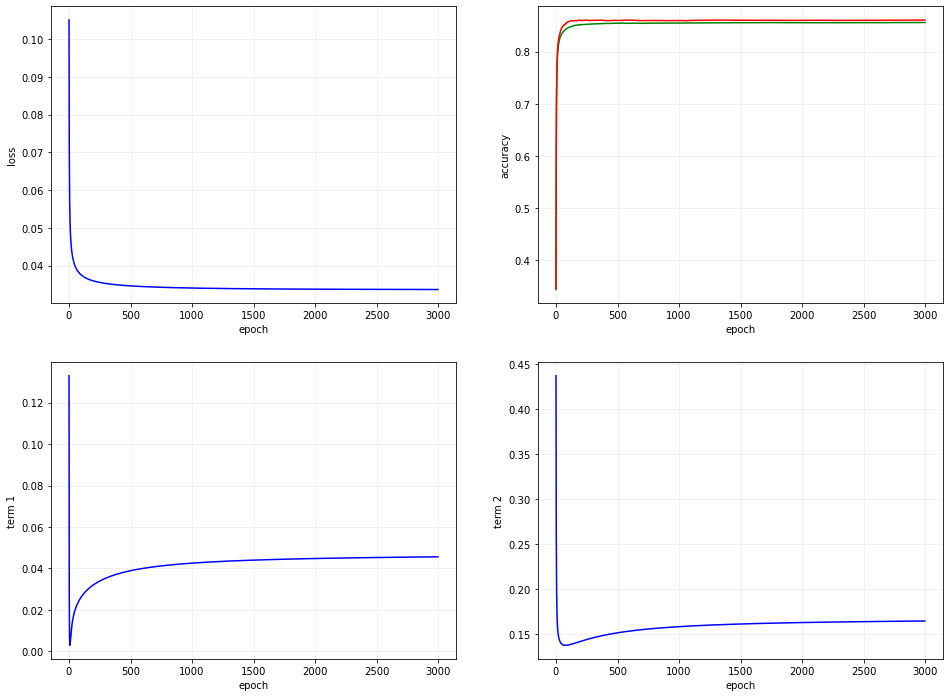

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

axs[0][0].plot(loss_tab, color='blue')
axs[0][1].plot(train_accuracy_tab, color='green')
axs[0][1].plot(test_accuracy_tab, color='red')

axs[1][0].plot(term_I_tab, color = 'blue')
axs[1][1].plot(term_II_tab, color = 'blue')

for row in axs:
    for ax in row:
        ax.grid(True, alpha =0.2)
        ax.set_xlabel('epoch')
        #ax.set_yscale('log')

axs[0][0].set_ylabel('loss')
axs[0][1].set_ylabel('accuracy')
axs[1][0].set_ylabel('term 1')
axs[1][1].set_ylabel('term 2')
plt.show()



In [9]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(255/256, 1, N)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, N)
vals[:, 2] = np.linspace(203/256, 1, N)  ## blue 75, 0, 130
Pinks = ListedColormap(vals)


top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)

newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))

newcmp = ListedColormap(newcolors, name='PinkPueple')

In [10]:
params=[]
for param in model.parameters():
    params.append(param.detach().numpy())
w1=params[0] 
w2=params[1]


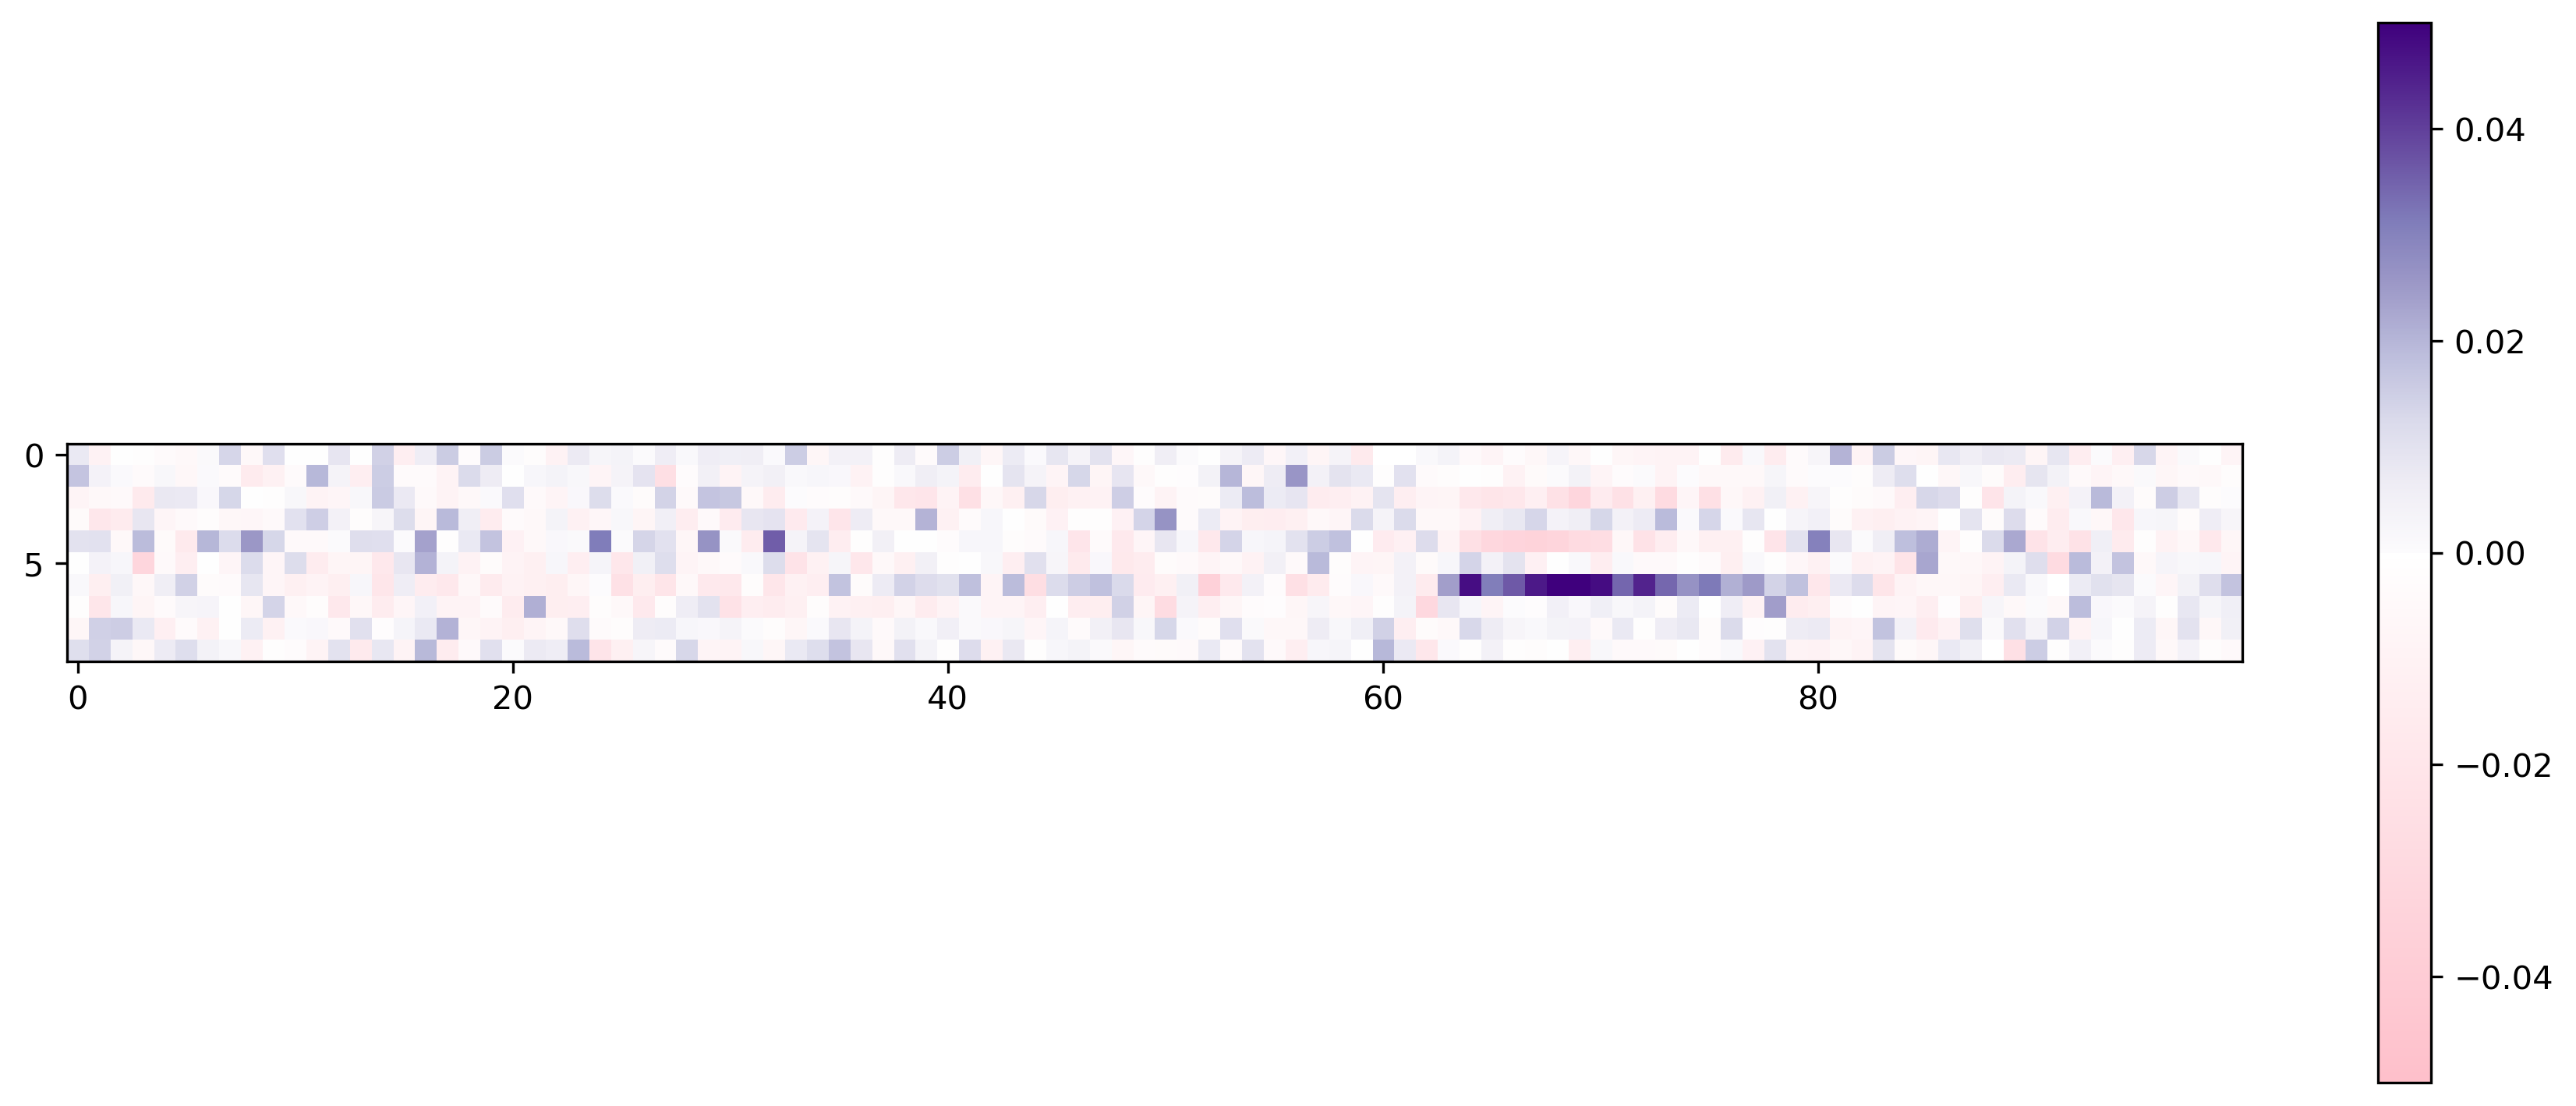

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW =  w2 @ w1 
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


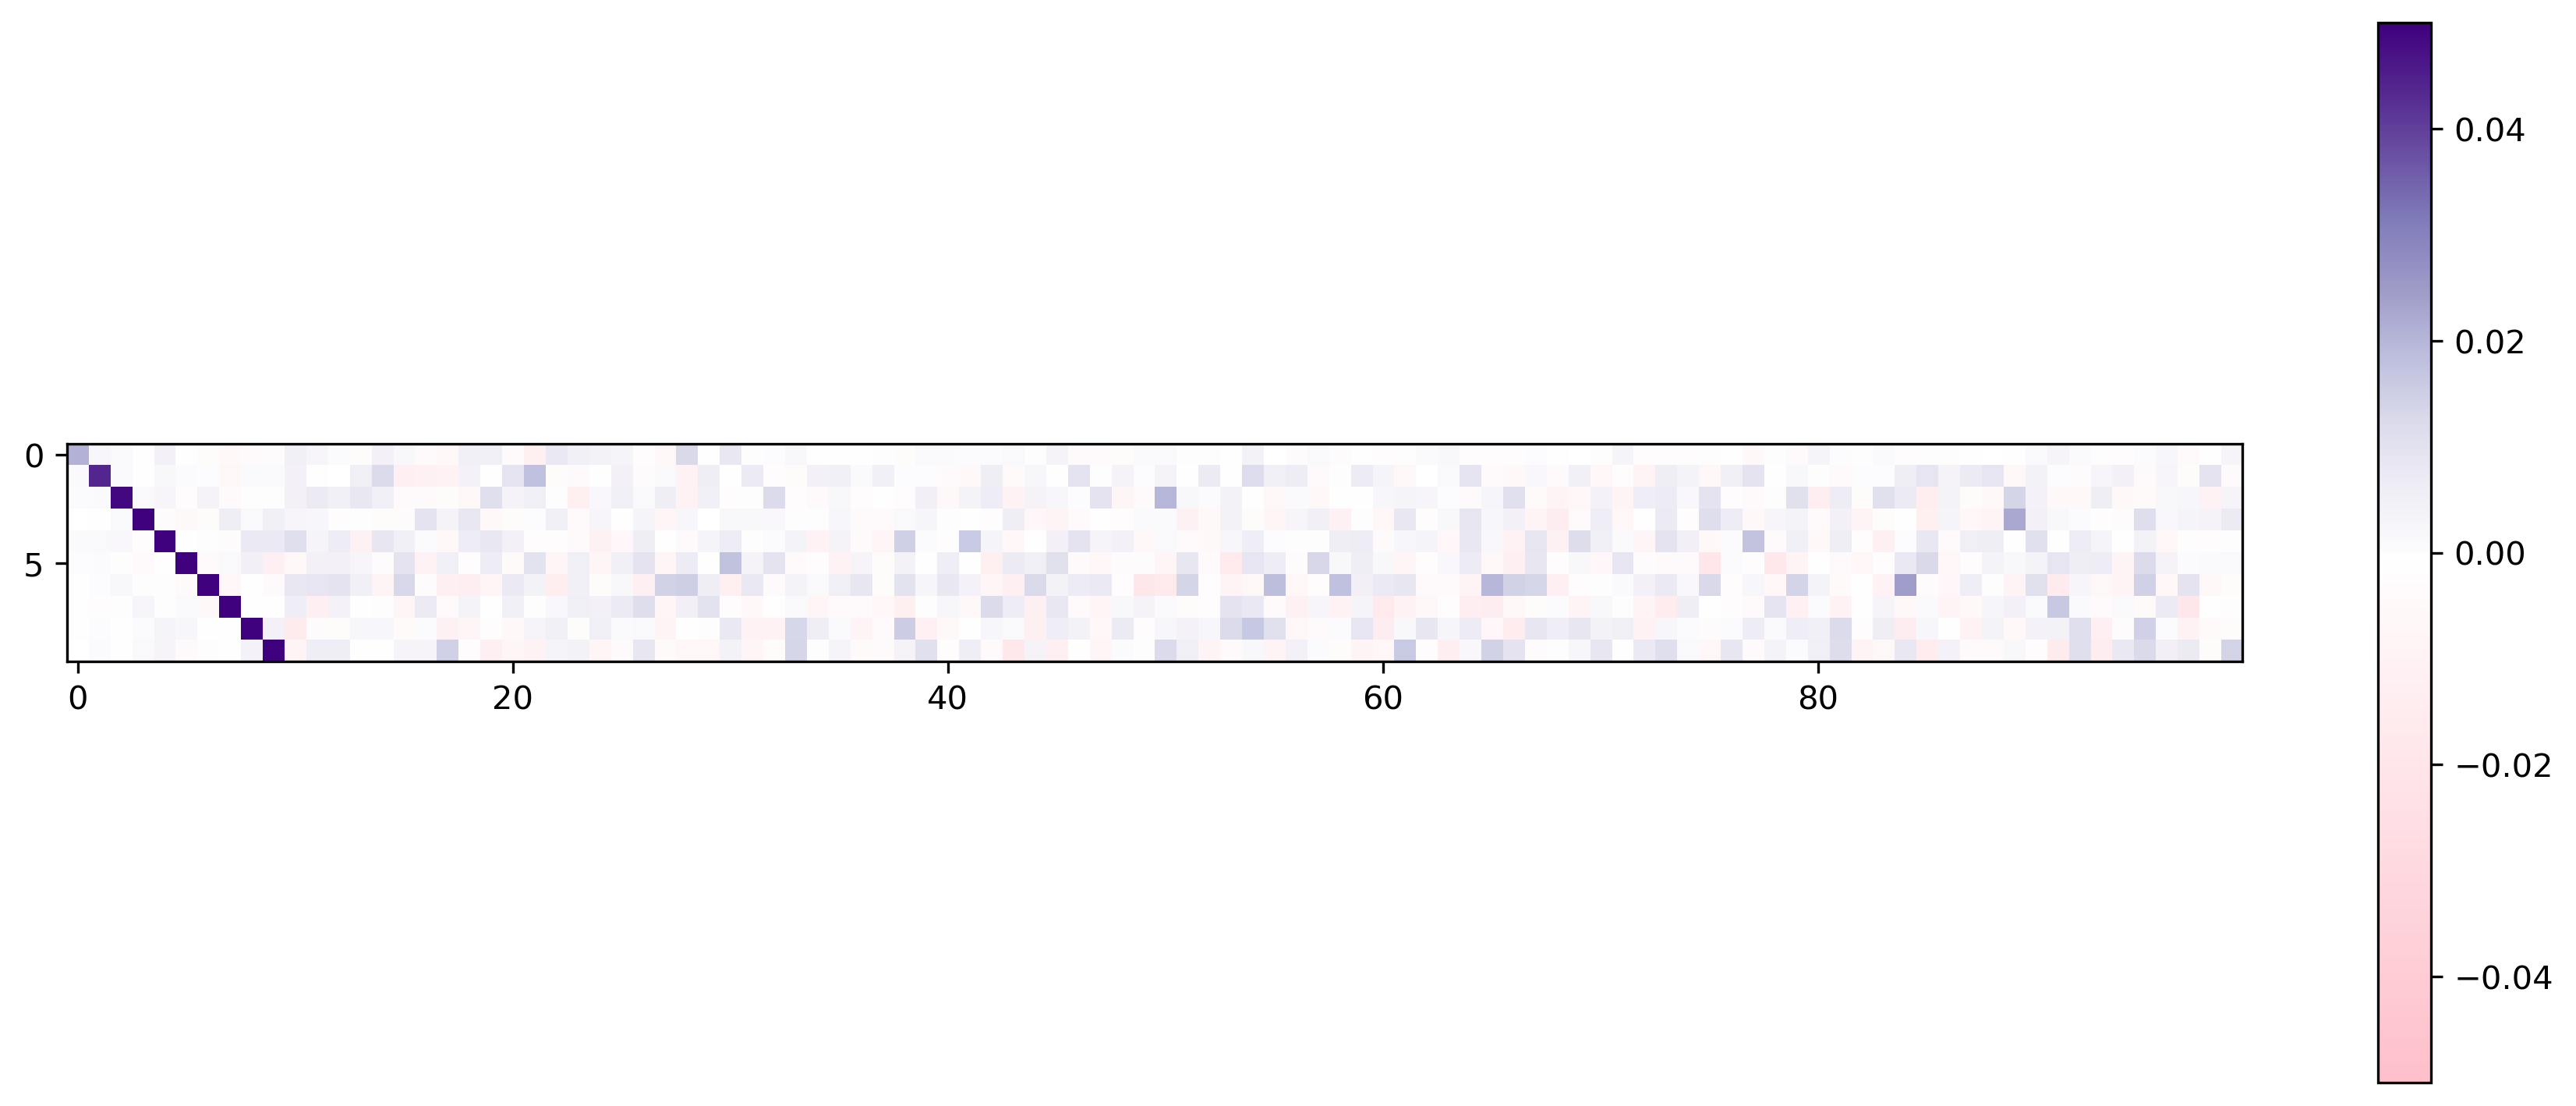

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


CHECK: $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$
$$ MSE= \frac{1}{P} \sum_{\mu=1}^P \lVert y - W^2 W^1 x \rVert ^2 $$ 

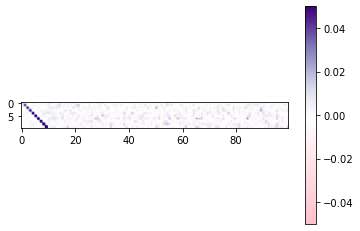

In [13]:
R = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( R[:, :100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

In [14]:
term_1 = 0
for alpha in range(10):
    term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
term_1



array([0.04563473])

In [15]:
term_2 = 0
for beta in range(10):
    for alpha in range(784):
        if(alpha != beta):
            term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
term_2


0.16491554540977493

In [16]:
term_3 = np.trace(S33_matrix)
term_3

1.000000009

In [17]:
term_4 = 0
for alpha in range(10):
    term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]
term_4   

array([0.49717632])

In [18]:
term_1+term_2+term_3-term_4

array([0.71337397])

In [19]:
term_3-term_4

array([0.50282369])

## terms with star: $T_1^*$,  $T_2^*$,  $T_4^*$

In [20]:
term_4 = 0
for alpha in range(10):
    term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
term_4   

0.7834476185280769

In [21]:
term_3-term_4

0.2165523904719232

In [22]:
term_2+term_3-term_4

0.38146793588169825

In [23]:
term_1+term_2+term_3-term_4

array([0.42710266])

# Final MSE on training / testing dataset


In [24]:
MSE_tab=[]
SE_model_tab=[]
SE_calc_tab=[]

batch_size: int = 1  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [25]:
with torch.no_grad():
    for i, (x,y) in enumerate(train_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc = w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on training set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on training set
MSE = 0.038272 	MSE_model = 0.382716	MSEcalc = 0.382716


In [26]:
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc =  w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on test set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on test set
MSE = 0.038272 	MSE_model = 0.382719	MSEcalc = 0.382719


# Save All

In [30]:
import pandas as pd

savefile = 'ground_energy_200.csv'
df = pd.DataFrame()

df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab


df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab
df['R'] = R_tab


df.to_csv(savefile, index=False)

df_w2= pd.DataFrame(np.array(w2_tab).T)
df_w3= pd.DataFrame(np.array(w3_tab).T)

df_w2.to_csv('ground_energy_200_w2.csv', index=False)
df_w3.to_csv('ground_energy_200_w3.csv', index=False)


In [29]:
w1=deepcopy(model.parameters()[0]).detach().numpy().reshape(input_dim*hidden_dim1)
w2=deepcopy(model.parameters()[1]).detach().numpy().reshape(hidden_dim1*output_dim)

df_w1 = pd.DataFrame(w1, columns = ['w1'] )
df_w2 = pd.DataFrame(w2, columns = ['w2'] )

df_w1.to_csv('w1.csv', index=False)
df_w2.to_csv('w2.csv', index=False)
